In [3]:
%load_ext autoreload
from utils import  generate_random_numbers, plot_distribution
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


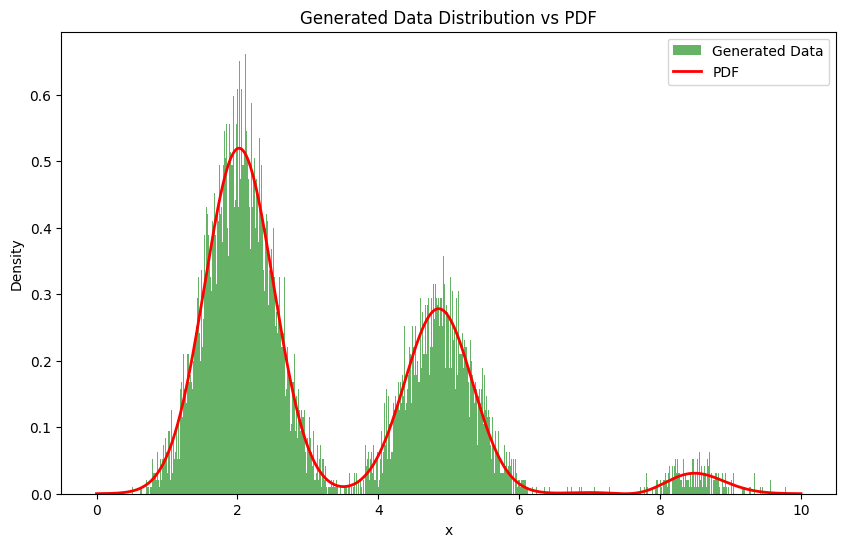

In [4]:
def custom_pdf(x):
    mean1, std1 = 2, 0.5
    mean2, std2 = 5, 0.5
    mean3, std3 = 8, 0.5

    gauss1 = np.exp(-0.5 * ((x - mean1) / std1) ** 2) / (std1 * np.sqrt(2 * np.pi))
    gauss2 = np.exp(-0.5 * ((x - mean2) / std2) ** 2) / (std2 * np.sqrt(2 * np.pi))
    gauss3 = np.exp(-0.5 * ((x - mean3) / std3) ** 2) / (std3 * np.sqrt(2 * np.pi))

    sinusoidal_modulation = 0.5 * (1 + np.sin(2 * np.pi * x / 10))

    return (gauss1 + gauss2 + gauss3) * sinusoidal_modulation
    # return gauss1 + gauss2 + gauss3


x_range = (0, 10)
num_samples = 10000
samples = generate_random_numbers(custom_pdf, x_range, num_samples)
plot_distribution(samples, custom_pdf, x_range)
